In [1]:
##############################
# IMPORT
##############################

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from google.cloud import bigquery as bq
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import shap
warnings.filterwarnings("ignore", category=UserWarning)
c = bq.Client.from_service_account_json("denizerendeg505.json")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)


def nn_predict(model, x):
    return (model.predict(x).flatten() > 0.5).astype(int)

def outlier_thresholds(dataframe, col_name, q1=0.01, q3=0.99):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
    


def replace_with_thresholds(dataframe, variable):
    dataframe[variable] = dataframe[variable].astype(float)
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


def feature_creater(input_x, y, candidate_features_dict:dict, candidate_features_id:list, best_score=0, model_name = None, scoring = "accuracy", cv = 5, best_frame = True, verbose = True):
    from lightgbm import LGBMClassifier
    from sklearn.model_selection import cross_validate
    if model_name not in ["xgboost","lightgbm","catboost"]:
        print("'model' is invalid.")
        return
    if not candidate_features_id:
        if best_frame:
            return best_score, input_x
        else:
            return best_score       
    best_x = input_x   
    best_feature= -1 
    if best_score == 0:
        if model_name == "xgboost":
            model = XGBClassifier(random_state=17, use_label_encoder=False).fit(input_x, y)
        elif model_name == "lightgbm":
            model = LGBMClassifier(random_state=17, verbose=-1).fit(input_x, y)
        elif model_name == "catboost":
            model = CatBoostClassifier(random_state=17, verbose=False).fit(input_x, y)
        cv_results = cross_validate(model,
                                    input_x, y,
                                    cv=cv,
                                    scoring=scoring)

        best_score = cv_results["test_score"].mean()

    if verbose:
       print(f"Best {scoring} (old) = {best_score}")
       #print(candidate_features_id) 
 
    for feature in candidate_features_id:       
            X = input_x.copy(deep=True)

            # define your candidate features here!
            if feature == 0:
                X[candidate_features_dict[feature]] = X["level_success"]/X["level_start"]

            elif feature == 1:
                X[candidate_features_dict[feature]] = X["coin_earn"]/(X["coin_spend"]+1)

            elif feature == 2:
                X[candidate_features_dict[feature]] = X["level_fail"]/(X["level_start"]+1)

            elif feature == 3:
                X[candidate_features_dict[feature]] = X["coin_earn"]/(X["coin_amount"]+1)

            elif feature == 4:
                X[candidate_features_dict[feature]] = X["coin_spend"]/(X["coin_amount"]+1)

            elif feature == 5:
                X[candidate_features_dict[feature]] = X["time_spend"]/(X["level_fail"]+1)

            elif feature == 6:
                X[candidate_features_dict[feature]] = X["coin_earn"]/(X["time_spend"]+1)

            elif feature == 7:
                X[candidate_features_dict[feature]] = X["event_participate"]/(X["time_spend"]+1)

            elif feature == 8:
                X[candidate_features_dict[feature]] = X["coin_earn"]/(X["shop_open"]+1)

            elif feature == 9:
                X[candidate_features_dict[feature]] =  X["booster_earn"]/(X["shop_open"]+1)

            elif feature == 10:
                X[candidate_features_dict[feature]] = X["time_spend"]/(X["shop_open"]+1)

            elif feature == 11:
                X[candidate_features_dict[feature]] = X["time_spend"]/(X["age"]+1)



            if model_name == "xgboost":
                model = XGBClassifier(random_state=17, use_label_encoder=False).fit(X, y)
            elif model_name == "lightgbm":
                model = LGBMClassifier(random_state=17, verbose=-1).fit(X, y)
            elif model_name == "catboost":
                model = CatBoostClassifier(random_state=17, verbose=False).fit(X, y)
            
            
            cv_results = cross_validate(model,
                                        X, y,
                                        cv=cv,
                                        scoring=scoring)
        
            score = cv_results["test_score"].mean()
            if score > best_score:
                best_score = score
                best_feature = feature
                best_x = X

    if best_feature == -1:
        if best_frame:
            return best_score, best_x
        else:
            return best_score
         
    candidate_features_id.remove(best_feature)

    if verbose:
       print(f"Best {scoring} (new) = {best_score}")  
       print(f"Added feature  = (id : {best_feature}, name : {candidate_features_dict[best_feature]})", end = '\n\n')   
    
    return feature_creater(best_x, y, candidate_features_dict, candidate_features_id, best_score, model_name, scoring, cv, best_frame, verbose)
    

In [2]:
query = """ 

SELECT
    platform,
    network,
    country,
    age,
    time_spend,
    coin_spend,
    coin_earn,
    level_success,
    level_fail,
    level_start,
    booster_spend,
    booster_earn,
    coin_amount,
    event_participate,
    shop_open,
    d30_revenue,
    CASE
        WHEN d30_revenue = 0 THEN 0
        ELSE 1
    END AS purchased
FROM
    casedreamgames.case_db.q3_table_user_metrics;

"""

df = c.query(query).to_dataframe()
df.head()

,platform,network,country,age,time_spend,coin_spend,coin_earn,level_success,level_fail,level_start,booster_spend,booster_earn,coin_amount,event_participate,shop_open,d30_revenue,purchased
0,ios,Oyster,Zephyra,53,71,0,0,0,0,0,0,0,2000,0,0.0,0.0,0
1,ios,Piggy,Thalassia,33,88,0,0,0,0,0,0,0,2000,0,0.0,0.0,0
2,ios,Piggy,Sunridge,64,2,0,0,0,0,0,0,0,2000,0,0.0,0.0,0
3,ios,Piggy,Zephyra,51,11,0,0,0,0,0,0,0,2000,0,0.0,0.0,0
4,ios,Piggy,Zephyra,70,38,0,0,0,0,0,0,0,2000,0,0.0,0.0,0


### i) EDA

In [3]:
# Kullanicilarin %7.83'u satin alma gerceklestirmis.
# Imbalanced dataset.
# ROC AUC ve F1 metrikleri kullanilabilir...
print(100*(df['purchased'].sum()/df.shape[0]))

7.834893830707202


In [3]:
# Hic null deger yok.
df.isna().sum()

platform             0
network              0
country              0
age                  0
time_spend           0
coin_spend           0
coin_earn            0
level_success        0
level_fail           0
level_start          0
booster_spend        0
booster_earn         0
coin_amount          0
event_participate    0
shop_open            0
d30_revenue          0
purchased            0
dtype: int64

In [4]:
# Degiskenlerde bir anomali yok.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,342519.0,47.051218,18.183999,16.0,31.0,47.0,63.0,78.0
time_spend,342519.0,7559.453175,10456.431879,0.0,579.0,2851.0,10745.0,201362.0
coin_spend,342519.0,20847.539845,35064.279228,0.0,0.0,4500.0,27000.0,1652000.0
coin_earn,342519.0,23439.894283,36909.192282,0.0,1315.0,7320.0,31820.0,1644045.0
level_success,342519.0,47.267944,59.634493,0.0,6.0,22.0,68.0,665.0
level_fail,342519.0,19.362213,36.787139,0.0,0.0,4.0,21.0,653.0
level_start,342519.0,66.630683,90.504488,0.0,7.0,26.0,93.0,1155.0
booster_spend,342519.0,20.721262,36.445079,0.0,0.0,5.0,23.0,506.0
booster_earn,342519.0,28.003489,43.490163,0.0,0.0,4.0,38.0,582.0
coin_amount,342519.0,2519.932792,2638.14952,0.0,1036.0,2051.0,2796.0,202229.0


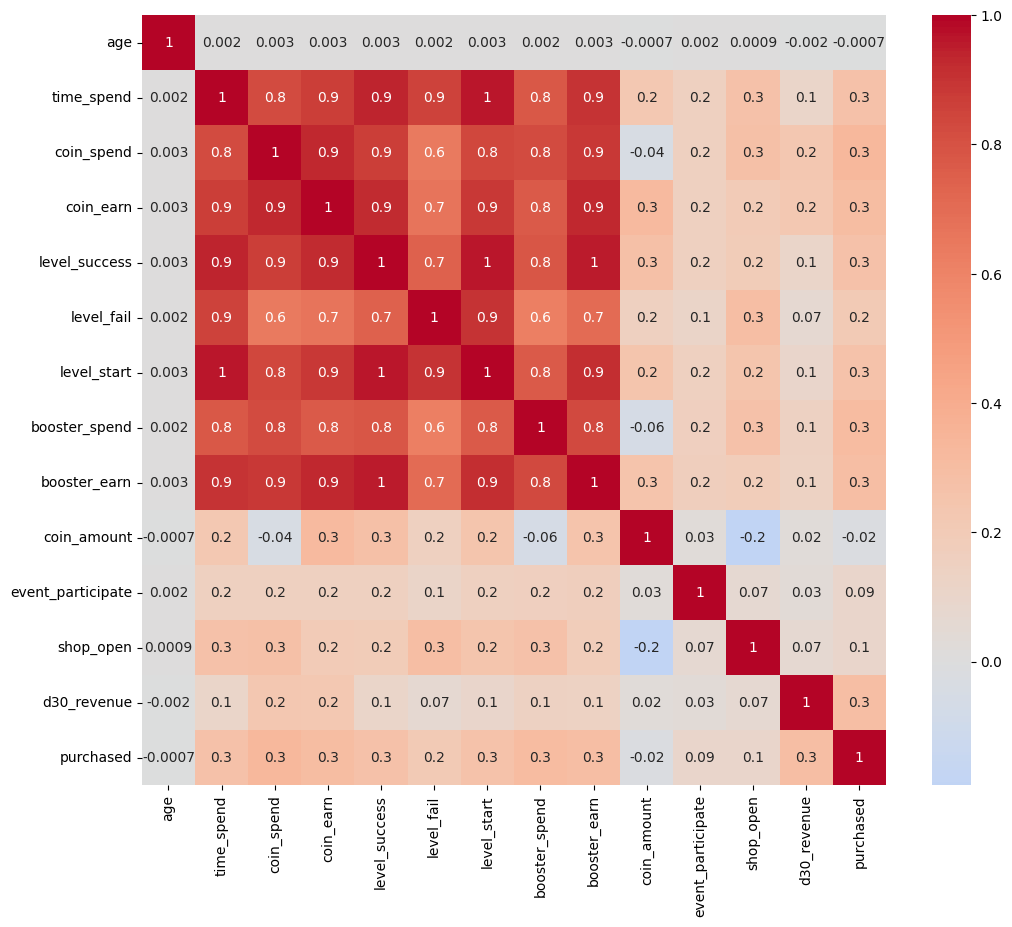

In [3]:
num_cols = [col for col in df.columns if df[col].dtypes != "O"]
non_num_cols = [col for col in df.columns if col not in num_cols]


# Numeric degiskenler arasindaki korelasyon
plt.figure(figsize=(12, 10))
corr_matrix = df[num_cols].corr()
sns.heatmap(corr_matrix,
            cmap="coolwarm",
            center=0,
            annot=True,
            fmt=".1g")

plt.show()

In [6]:
# Outlier kontrolu
for col in num_cols:
    print(col, check_outlier(df, col))

age False
time_spend True
coin_spend True
coin_earn True
level_success True
level_fail True
level_start True
booster_spend True
booster_earn True
coin_amount True
event_participate False
shop_open True
d30_revenue True
purchased False


In [4]:
# Outlier'lari replace et..
for col in num_cols:
    replace_with_thresholds(df, col)


for col in num_cols:
    print(col, check_outlier(df, col))

age False
time_spend False
coin_spend False
coin_earn False
level_success False
level_fail False
level_start False
booster_spend False
booster_earn False
coin_amount False
event_participate False
shop_open False
d30_revenue False
purchased False


### ii) Feature Engineering

In [20]:
# Yas gruplama
# One hot encoding
# Standard Scaling
x = df.drop(["purchased","d30_revenue"], axis=1)
y = df["purchased"]
x.loc[(x["age"] <= 28 ), "age_cat"] = "young"
x.loc[(x["age"] > 28 ) & (x["age"] <= 41), "age_cat"] = "early_adult"
x.loc[(x["age"] > 41 ) & (x["age"] <= 53), "age_cat"] = "mid_adult"
x.loc[(x["age"] > 53 ) & (x["age"] <= 66), "age_cat"] = "late_adult"
x.loc[(x["age"] > 66), "age_cat"] = "old"
x = pd.get_dummies(x, columns=[col for col in x.columns if x[col].dtypes == "O"])
scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)
x.head()

,age,time_spend,coin_spend,coin_earn,level_success,level_fail,level_start,booster_spend,booster_earn,coin_amount,event_participate,shop_open,platform_android,platform_ios,network_Bird,network_Box,network_Cupboard,network_Curtain,network_Dynamite,network_Egg,network_Grass,network_Honey,network_Mailbox,network_Owl,network_Oyster,network_Piggy,network_Potion,network_Vase,country_Amaryllis,country_Azurelia,country_Brighthaven,country_Crystalbrook,country_Eldoria,country_Emberlyn,country_Floravia,country_Frostford,country_Gleamwood,country_Glimmerdell,country_Luminara,country_Moonvale,country_Rosewyn,country_Seraphina,country_Silvermist,country_Starcliff,country_Sunridge,country_Thalassia,country_Windemere,country_Zephyra,age_cat_early_adult,age_cat_late_adult,age_cat_mid_adult,age_cat_old,age_cat_young
0,0.327144,-0.716832,-0.620552,-0.666264,-0.79265,-0.527489,-0.7363,-0.568711,-0.644481,-0.2001,-0.206865,-0.377723,-1.026915,1.026915,-0.093652,-0.144893,-0.147611,-0.169465,-0.202936,-0.30962,-0.297528,-0.109415,-0.131451,-0.443865,2.013656,-0.529900,-0.089734,-0.323404,-0.235452,-0.156319,-0.189958,-0.086743,-0.162017,-0.408928,-0.233581,-0.088251,-0.218899,-0.082867,-0.237063,-0.308843,-0.190312,-0.161199,-0.142042,-0.117251,-0.150750,-0.136020,-0.201214,1.575138,-0.507722,-0.510477,2.056778,-0.486138,-0.509336
1,-0.772725,-0.715205,-0.620552,-0.666264,-0.79265,-0.527489,-0.7363,-0.568711,-0.644481,-0.2001,-0.206865,-0.377723,-1.026915,1.026915,-0.093652,-0.144893,-0.147611,-0.169465,-0.202936,-0.30962,-0.297528,-0.109415,-0.131451,-0.443865,-0.496609,1.887147,-0.089734,-0.323404,-0.235452,-0.156319,-0.189958,-0.086743,-0.162017,-0.408928,-0.233581,-0.088251,-0.218899,-0.082867,-0.237063,-0.308843,-0.190312,-0.161199,-0.142042,-0.117251,-0.150750,7.351848,-0.201214,-0.634865,1.969583,-0.510477,-0.486197,-0.486138,-0.509336
2,0.932073,-0.723438,-0.620552,-0.666264,-0.79265,-0.527489,-0.7363,-0.568711,-0.644481,-0.2001,-0.206865,-0.377723,-1.026915,1.026915,-0.093652,-0.144893,-0.147611,-0.169465,-0.202936,-0.30962,-0.297528,-0.109415,-0.131451,-0.443865,-0.496609,1.887147,-0.089734,-0.323404,-0.235452,-0.156319,-0.189958,-0.086743,-0.162017,-0.408928,-0.233581,-0.088251,-0.218899,-0.082867,-0.237063,-0.308843,-0.190312,-0.161199,-0.142042,-0.117251,6.633487,-0.136020,-0.201214,-0.634865,-0.507722,1.958953,-0.486197,-0.486138,-0.509336
3,0.217157,-0.722576,-0.620552,-0.666264,-0.79265,-0.527489,-0.7363,-0.568711,-0.644481,-0.2001,-0.206865,-0.377723,-1.026915,1.026915,-0.093652,-0.144893,-0.147611,-0.169465,-0.202936,-0.30962,-0.297528,-0.109415,-0.131451,-0.443865,-0.496609,1.887147,-0.089734,-0.323404,-0.235452,-0.156319,-0.189958,-0.086743,-0.162017,-0.408928,-0.233581,-0.088251,-0.218899,-0.082867,-0.237063,-0.308843,-0.190312,-0.161199,-0.142042,-0.117251,-0.150750,-0.136020,-0.201214,1.575138,-0.507722,-0.510477,2.056778,-0.486138,-0.509336
4,1.262034,-0.719991,-0.620552,-0.666264,-0.79265,-0.527489,-0.7363,-0.568711,-0.644481,-0.2001,-0.206865,-0.377723,-1.026915,1.026915,-0.093652,-0.144893,-0.147611,-0.169465,-0.202936,-0.30962,-0.297528,-0.109415,-0.131451,-0.443865,-0.496609,1.887147,-0.089734,-0.323404,-0.235452,-0.156319,-0.189958,-0.086743,-0.162017,-0.408928,-0.233581,-0.088251,-0.218899,-0.082867,-0.237063,-0.308843,-0.190312,-0.161199,-0.142042,-0.117251,-0.150750,-0.136020,-0.201214,1.575138,-0.507722,-0.510477,-0.486197,2.057030,-0.509336


In [9]:
# Feature turetme
candidate_features = {0:"level_success/level_start",
            1:"coin_earn/coin_spend",
            2:"level_fail/level_start",
            3:"coin_earn/coin_amount",
            4:"coin_spend/coin_amount",
            5:"time_spend/level_fail",
            6:"coin_earn/time_spend",
            7:"time_spend/age",
            8:"event_participate/time_spend",
            9:"coin_earn/shop_open",
            10:"booster_earn/shop_open",
            11:"shop_open/time_spend"}

roc_score, x = feature_creater(x,y,candidate_features, list(candidate_features.keys()), model_name="lightgbm", scoring="roc_auc")

Best roc_auc (old) = 0.22736291575619366
Best roc_auc (new) = 0.23741273851665481
Added feature  = (id : 7, name : time_spend/age)

Best roc_auc (old) = 0.23741273851665481
Best roc_auc (new) = 0.23756023250565153
Added feature  = (id : 4, name : coin_spend/coin_amount)

Best roc_auc (old) = 0.23756023250565153


In [22]:
x["time_spend/age"] = (x["time_spend"]/x["age"])
x["coin_spend/coin_amount"] = (x["coin_spend"]/x["coin_amount"])
x.head()

,age,time_spend,coin_spend,coin_earn,level_success,level_fail,level_start,booster_spend,booster_earn,coin_amount,event_participate,shop_open,platform_android,platform_ios,network_Bird,network_Box,network_Cupboard,network_Curtain,network_Dynamite,network_Egg,network_Grass,network_Honey,network_Mailbox,network_Owl,network_Oyster,network_Piggy,network_Potion,network_Vase,country_Amaryllis,country_Azurelia,country_Brighthaven,country_Crystalbrook,country_Eldoria,country_Emberlyn,country_Floravia,country_Frostford,country_Gleamwood,country_Glimmerdell,country_Luminara,country_Moonvale,country_Rosewyn,country_Seraphina,country_Silvermist,country_Starcliff,country_Sunridge,country_Thalassia,country_Windemere,country_Zephyra,age_cat_early_adult,age_cat_late_adult,age_cat_mid_adult,age_cat_old,age_cat_young,time_spend/age,coin_spend/coin_amount
0,0.327144,-0.716832,-0.620552,-0.666264,-0.79265,-0.527489,-0.7363,-0.568711,-0.644481,-0.2001,-0.206865,-0.377723,-1.026915,1.026915,-0.093652,-0.144893,-0.147611,-0.169465,-0.202936,-0.30962,-0.297528,-0.109415,-0.131451,-0.443865,2.013656,-0.529900,-0.089734,-0.323404,-0.235452,-0.156319,-0.189958,-0.086743,-0.162017,-0.408928,-0.233581,-0.088251,-0.218899,-0.082867,-0.237063,-0.308843,-0.190312,-0.161199,-0.142042,-0.117251,-0.150750,-0.136020,-0.201214,1.575138,-0.507722,-0.510477,2.056778,-0.486138,-0.509336,-2.191180,3.101213
1,-0.772725,-0.715205,-0.620552,-0.666264,-0.79265,-0.527489,-0.7363,-0.568711,-0.644481,-0.2001,-0.206865,-0.377723,-1.026915,1.026915,-0.093652,-0.144893,-0.147611,-0.169465,-0.202936,-0.30962,-0.297528,-0.109415,-0.131451,-0.443865,-0.496609,1.887147,-0.089734,-0.323404,-0.235452,-0.156319,-0.189958,-0.086743,-0.162017,-0.408928,-0.233581,-0.088251,-0.218899,-0.082867,-0.237063,-0.308843,-0.190312,-0.161199,-0.142042,-0.117251,-0.150750,7.351848,-0.201214,-0.634865,1.969583,-0.510477,-0.486197,-0.486138,-0.509336,0.925561,3.101213
2,0.932073,-0.723438,-0.620552,-0.666264,-0.79265,-0.527489,-0.7363,-0.568711,-0.644481,-0.2001,-0.206865,-0.377723,-1.026915,1.026915,-0.093652,-0.144893,-0.147611,-0.169465,-0.202936,-0.30962,-0.297528,-0.109415,-0.131451,-0.443865,-0.496609,1.887147,-0.089734,-0.323404,-0.235452,-0.156319,-0.189958,-0.086743,-0.162017,-0.408928,-0.233581,-0.088251,-0.218899,-0.082867,-0.237063,-0.308843,-0.190312,-0.161199,-0.142042,-0.117251,6.633487,-0.136020,-0.201214,-0.634865,-0.507722,1.958953,-0.486197,-0.486138,-0.509336,-0.776160,3.101213
3,0.217157,-0.722576,-0.620552,-0.666264,-0.79265,-0.527489,-0.7363,-0.568711,-0.644481,-0.2001,-0.206865,-0.377723,-1.026915,1.026915,-0.093652,-0.144893,-0.147611,-0.169465,-0.202936,-0.30962,-0.297528,-0.109415,-0.131451,-0.443865,-0.496609,1.887147,-0.089734,-0.323404,-0.235452,-0.156319,-0.189958,-0.086743,-0.162017,-0.408928,-0.233581,-0.088251,-0.218899,-0.082867,-0.237063,-0.308843,-0.190312,-0.161199,-0.142042,-0.117251,-0.150750,-0.136020,-0.201214,1.575138,-0.507722,-0.510477,2.056778,-0.486138,-0.509336,-3.327432,3.101213
4,1.262034,-0.719991,-0.620552,-0.666264,-0.79265,-0.527489,-0.7363,-0.568711,-0.644481,-0.2001,-0.206865,-0.377723,-1.026915,1.026915,-0.093652,-0.144893,-0.147611,-0.169465,-0.202936,-0.30962,-0.297528,-0.109415,-0.131451,-0.443865,-0.496609,1.887147,-0.089734,-0.323404,-0.235452,-0.156319,-0.189958,-0.086743,-0.162017,-0.408928,-0.233581,-0.088251,-0.218899,-0.082867,-0.237063,-0.308843,-0.190312,-0.161199,-0.142042,-0.117251,-0.150750,-0.136020,-0.201214,1.575138,-0.507722,-0.510477,-0.486197,2.057030,-0.509336,-0.570501,3.101213


In [11]:
x.head()

,age,time_spend,coin_spend,coin_earn,level_success,level_fail,level_start,booster_spend,booster_earn,coin_amount,event_participate,shop_open,platform_android,platform_ios,network_Bird,network_Box,network_Cupboard,network_Curtain,network_Dynamite,network_Egg,network_Grass,network_Honey,network_Mailbox,network_Owl,network_Oyster,network_Piggy,network_Potion,network_Vase,country_Amaryllis,country_Azurelia,country_Brighthaven,country_Crystalbrook,country_Eldoria,country_Emberlyn,country_Floravia,country_Frostford,country_Gleamwood,country_Glimmerdell,country_Luminara,country_Moonvale,country_Rosewyn,country_Seraphina,country_Silvermist,country_Starcliff,country_Sunridge,country_Thalassia,country_Windemere,country_Zephyra,age_cat_early_adult,age_cat_late_adult,age_cat_mid_adult,age_cat_old,age_cat_young,time_spend/age,coin_spend/coin_amount
0,0.327144,-0.716832,-0.620552,-0.666264,-0.79265,-0.527489,-0.7363,-0.568711,-0.644481,-0.2001,-0.206865,-0.377723,-1.026915,1.026915,-0.093652,-0.144893,-0.147611,-0.169465,-0.202936,-0.30962,-0.297528,-0.109415,-0.131451,-0.443865,2.013656,-0.529900,-0.089734,-0.323404,-0.235452,-0.156319,-0.189958,-0.086743,-0.162017,-0.408928,-0.233581,-0.088251,-0.218899,-0.082867,-0.237063,-0.308843,-0.190312,-0.161199,-0.142042,-0.117251,-0.150750,-0.136020,-0.201214,1.575138,-0.507722,-0.510477,2.056778,-0.486138,-0.509336,-0.730539,-0.775787
1,-0.772725,-0.715205,-0.620552,-0.666264,-0.79265,-0.527489,-0.7363,-0.568711,-0.644481,-0.2001,-0.206865,-0.377723,-1.026915,1.026915,-0.093652,-0.144893,-0.147611,-0.169465,-0.202936,-0.30962,-0.297528,-0.109415,-0.131451,-0.443865,-0.496609,1.887147,-0.089734,-0.323404,-0.235452,-0.156319,-0.189958,-0.086743,-0.162017,-0.408928,-0.233581,-0.088251,-0.218899,-0.082867,-0.237063,-0.308843,-0.190312,-0.161199,-0.142042,-0.117251,-0.150750,7.351848,-0.201214,-0.634865,1.969583,-0.510477,-0.486197,-0.486138,-0.509336,-0.726364,-0.775787
2,0.932073,-0.723438,-0.620552,-0.666264,-0.79265,-0.527489,-0.7363,-0.568711,-0.644481,-0.2001,-0.206865,-0.377723,-1.026915,1.026915,-0.093652,-0.144893,-0.147611,-0.169465,-0.202936,-0.30962,-0.297528,-0.109415,-0.131451,-0.443865,-0.496609,1.887147,-0.089734,-0.323404,-0.235452,-0.156319,-0.189958,-0.086743,-0.162017,-0.408928,-0.233581,-0.088251,-0.218899,-0.082867,-0.237063,-0.308843,-0.190312,-0.161199,-0.142042,-0.117251,6.633487,-0.136020,-0.201214,-0.634865,-0.507722,1.958953,-0.486197,-0.486138,-0.509336,-0.747988,-0.775787
3,0.217157,-0.722576,-0.620552,-0.666264,-0.79265,-0.527489,-0.7363,-0.568711,-0.644481,-0.2001,-0.206865,-0.377723,-1.026915,1.026915,-0.093652,-0.144893,-0.147611,-0.169465,-0.202936,-0.30962,-0.297528,-0.109415,-0.131451,-0.443865,-0.496609,1.887147,-0.089734,-0.323404,-0.235452,-0.156319,-0.189958,-0.086743,-0.162017,-0.408928,-0.233581,-0.088251,-0.218899,-0.082867,-0.237063,-0.308843,-0.190312,-0.161199,-0.142042,-0.117251,-0.150750,-0.136020,-0.201214,1.575138,-0.507722,-0.510477,2.056778,-0.486138,-0.509336,-0.745665,-0.775787
4,1.262034,-0.719991,-0.620552,-0.666264,-0.79265,-0.527489,-0.7363,-0.568711,-0.644481,-0.2001,-0.206865,-0.377723,-1.026915,1.026915,-0.093652,-0.144893,-0.147611,-0.169465,-0.202936,-0.30962,-0.297528,-0.109415,-0.131451,-0.443865,-0.496609,1.887147,-0.089734,-0.323404,-0.235452,-0.156319,-0.189958,-0.086743,-0.162017,-0.408928,-0.233581,-0.088251,-0.218899,-0.082867,-0.237063,-0.308843,-0.190312,-0.161199,-0.142042,-0.117251,-0.150750,-0.136020,-0.201214,1.575138,-0.507722,-0.510477,-0.486197,2.057030,-0.509336,-0.738782,-0.775787


In [52]:
# Model secimi icin train test ayirimi
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=17)


### iii) Model Selection

1) Shallow Neural Network

In [78]:
shallow_nn = Sequential()
shallow_nn.add(InputLayer((x.shape[1], )))
shallow_nn.add(Dense(2, "relu"))
shallow_nn.add(BatchNormalization())
shallow_nn.add(Dense(1, "sigmoid"))
checkpoint = ModelCheckpoint("shallow_nn.keras", save_best_only=True)
shallow_nn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["AUC"])
shallow_nn.summary()
shallow_nn.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, callbacks=checkpoint)
print(classification_report(y_test, nn_predict(shallow_nn, x_test), target_names=["Not Purchased","Purchased"]))

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 2)              │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 2)              │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123 (492.00 B)

 Trainable params: 119 (476.00 B)

 Non-trainable params: 4 (16.00 B)

Epoch 1/5
7493/7493 ━━━━━━━━━━━━━━━━━━━━ 7s 838us/step - AUC: 0.6754 - loss: 0.3347 - val_AUC: 0.8210 - val_loss: 0.2199
Epoch 2/5
7493/7493 ━━━━━━━━━━━━━━━━━━━━ 6s 814us/step - AUC: 0.8260 - loss: 0.2215 - val_AUC: 0.8394 - val_loss: 0.2086
Epoch 3/5
7493/7493 ━━━━━━━━━━━━━━━━━━━━ 7s 880us/step - AUC: 0.8331 - loss: 0.2140 - val_AUC: 0.8475 - val_loss: 0.2044
Epoch 4/5
7493/7493 ━━━━━━━━━━━━━━━━━━━━ 6s 819us/step - AUC: 0.8420 - loss: 0.2099 - val_AUC: 0.8547 - val_loss: 0.2003
Epoch 5/5
7493/7493 ━━━━━━━━━━━━━━━━━━━━ 6s 814us/step - AUC: 0.8454 - loss: 0.2079 - val_AUC: 0.8575 - val_loss: 0.1989
3212/3212 ━━━━━━━━━━━━━━━━━━━━ 1s 404us/step
               precision    recall  f1-score   support

Not Purchased       0.93      1.00      0.96     94826
    Purchased       0.79      0.13      0.22      7930

     accuracy                           0.93    102756
    macro avg       0.86      0.56      0.59    102756
 weighted avg       0.92      0.93      0.91    102756



2) Logistic Regression

In [80]:
logistic_model = LogisticRegression(max_iter=5000)
logistic_model.fit(x_train, y_train)
print(classification_report(y_test, logistic_model.predict(x_test), target_names=["Not Purchased","Purchased"]))
y_train_pred_proba = logistic_model.predict_proba(x_train)[:, 1]
y_test_pred_proba = logistic_model.predict_proba(x_test)[:, 1]
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
print(f'Train ROC AUC: {train_roc_auc:.4f}')
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
print(f'Test ROC AUC: {test_roc_auc:.4f}')

               precision    recall  f1-score   support

Not Purchased       0.93      0.99      0.96     94826
    Purchased       0.65      0.16      0.26      7930

     accuracy                           0.93    102756
    macro avg       0.79      0.58      0.61    102756
 weighted avg       0.91      0.93      0.91    102756

Train ROC AUC: 0.8376
Test ROC AUC: 0.8378


3) Random Forest

In [81]:
rf = RandomForestClassifier(max_depth=1000, n_jobs=-1)
rf.fit(x_train, y_train)
print(classification_report(y_test, rf.predict(x_test), target_names=["Not Purchased","Purchased"]))
y_train_pred_proba = rf.predict_proba(x_train)[:, 1]
y_test_pred_proba = rf.predict_proba(x_test)[:, 1]
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
print(f'Train ROC AUC: {train_roc_auc:.4f}')
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
print(f'Test ROC AUC: {test_roc_auc:.4f}')

               precision    recall  f1-score   support

Not Purchased       0.93      1.00      0.96     94826
    Purchased       0.74      0.16      0.26      7930

     accuracy                           0.93    102756
    macro avg       0.84      0.58      0.61    102756
 weighted avg       0.92      0.93      0.91    102756

Train ROC AUC: 1.0000
Test ROC AUC: 0.8494


4) Gradient Boosting

In [83]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1000, random_state=17)
gbc.fit(x_train, y_train)
print(classification_report(y_test, gbc.predict(x_test), target_names=["Not Purchased","Purchased"]))
y_train_pred_proba = gbc.predict_proba(x_train)[:, 1]
y_test_pred_proba = gbc.predict_proba(x_test)[:, 1]
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
print(f'Train ROC AUC: {train_roc_auc:.4f}')
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
print(f'Test ROC AUC: {test_roc_auc:.4f}')

               precision    recall  f1-score   support

Not Purchased       0.94      0.94      0.94     94826
    Purchased       0.28      0.30      0.29      7930

     accuracy                           0.89    102756
    macro avg       0.61      0.62      0.62    102756
 weighted avg       0.89      0.89      0.89    102756

Train ROC AUC: 1.0000
Test ROC AUC: 0.7992


5) Support Vector Machine (SVC)

In [84]:
svc = LinearSVC(class_weight="balanced")
svc.fit(x_train, y_train)
print(classification_report(y_test, svc.predict(x_test), target_names=["Not Purchased","Purchased"]))
y_train_pred_proba = svc._predict_proba_lr(x_train)[:, 1]
y_test_pred_proba = svc._predict_proba_lr(x_test)[:, 1]
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
print(f'Train ROC AUC: {train_roc_auc:.4f}')
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
print(f'Test ROC AUC: {test_roc_auc:.4f}')

c:\Users\danim\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


               precision    recall  f1-score   support

Not Purchased       0.97      0.79      0.87     94826
    Purchased       0.22      0.71      0.34      7930

     accuracy                           0.79    102756
    macro avg       0.60      0.75      0.61    102756
 weighted avg       0.91      0.79      0.83    102756

Train ROC AUC: 0.8366
Test ROC AUC: 0.8362


6) LightGBM

In [85]:
lgb_model = LGBMClassifier(random_state=17, verbose=-1).fit(x_train, y_train)
print(classification_report(y_test, lgb_model.predict(x_test), target_names=["Not Purchased","Purchased"]))
y_train_pred_proba = lgb_model.predict_proba(x_train)[:, 1]
y_test_pred_proba = lgb_model.predict_proba(x_test)[:, 1]
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
print(f'Train ROC AUC: {train_roc_auc:.4f}')
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
print(f'Test ROC AUC: {test_roc_auc:.4f}')

               precision    recall  f1-score   support

Not Purchased       0.93      1.00      0.96     94826
    Purchased       0.77      0.17      0.28      7930

     accuracy                           0.93    102756
    macro avg       0.85      0.58      0.62    102756
 weighted avg       0.92      0.93      0.91    102756

Train ROC AUC: 0.8846
Test ROC AUC: 0.8702


7) XGBoost

In [86]:
xgb_model = XGBClassifier(random_state=17, use_label_encoder=False).fit(x_train, y_train)
print(classification_report(y_test, xgb_model.predict(x_test), target_names=["Not Purchased","Purchased"]))
y_train_pred_proba = xgb_model.predict_proba(x_train)[:, 1]
y_test_pred_proba = xgb_model.predict_proba(x_test)[:, 1]
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
print(f'Train ROC AUC: {train_roc_auc:.4f}')
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
print(f'Test ROC AUC: {test_roc_auc:.4f}')

               precision    recall  f1-score   support

Not Purchased       0.94      0.99      0.96     94826
    Purchased       0.72      0.19      0.31      7930

     accuracy                           0.93    102756
    macro avg       0.83      0.59      0.64    102756
 weighted avg       0.92      0.93      0.91    102756

Train ROC AUC: 0.9040
Test ROC AUC: 0.8674


8) CatBoost

In [87]:
cat_model = CatBoostClassifier(random_state=17, verbose=False).fit(x_train, y_train)
print(classification_report(y_test, cat_model.predict(x_test), target_names=["Not Purchased","Purchased"]))
y_train_pred_proba = cat_model.predict_proba(x_train)[:, 1]
y_test_pred_proba = cat_model.predict_proba(x_test)[:, 1]
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
print(f'Train ROC AUC: {train_roc_auc:.4f}')
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
print(f'Test ROC AUC: {test_roc_auc:.4f}')

               precision    recall  f1-score   support

Not Purchased       0.94      0.99      0.96     94826
    Purchased       0.74      0.20      0.32      7930

     accuracy                           0.93    102756
    macro avg       0.84      0.60      0.64    102756
 weighted avg       0.92      0.93      0.91    102756

Train ROC AUC: 0.9011
Test ROC AUC: 0.8710


### iv) Hyperparameter Tuning for CatBoost Model

In [8]:
# Model x_train_test ve y_train_test datasiyla egitilecek. 
# x_val ve y_val validasyon sirasinda kullanilacak, egitmie dahil olmayacak.
x_train_test, x_val, y_train_test, y_val = train_test_split(x, y, test_size=0.1, random_state=17)

In [113]:
# Optuna fonksiyonlari
def objective(trial):
    
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        )
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    model = CatBoostClassifier(**param, verbose=False)

    cv_results = cross_validate(model,
                                x_train_test, 
                                y_train_test,
                                cv=3,
                                scoring="roc_auc",
                                n_jobs=-1)

    score = cv_results["test_score"].mean()

    return score



def logging_callback(study, frozen_trial):
    previous_best_value = study.user_attrs.get("previous_best_value", 0)
    #if frozen_trial.number % 100 == 0:
    #    print(f"Trial {frozen_trial.number} has started.")
    print(f"Trial {frozen_trial.number} has started.")  
    if study.best_value > previous_best_value: 
        print(
            "Trial {} finished with best value: {} and parameters: {}. ".format(
            frozen_trial.number,
            frozen_trial.value,
            frozen_trial.params,
            )
        )
    study.set_user_attr("previous_best_value", study.best_value)

In [115]:
# Optunayi calistiriyoruz...

import optuna
optuna.logging.set_verbosity(optuna.logging.WARN)
study = optuna.create_study(study_name="catboost_params", 
                            direction="maximize", 
                            sampler=optuna.samplers.TPESampler(),
                            pruner=optuna.pruners.HyperbandPruner())


study.optimize(objective, timeout=5400, callbacks=[logging_callback], n_jobs=-1)

Trial 6 has started.
Trial 6 finished with best value: 0.8622539410522602 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.09607882294086542, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. 
Trial 0 has started.
Trial 0 finished with best value: 0.865474093307666 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.04058982589773428, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3231478204935975}. 
Trial 5 has started.
Trial 10 has started.
Trial 11 has started.
Trial 3 has started.
Trial 3 finished with best value: 0.8668668772474873 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.03729236647912114, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. 
Trial 1 has started.
Trial 1 finished with best value: 0.8678283662847779 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.03908507725635574, 'depth': 11, 'boosting_type': 'Plain', 'bootstrap_type

### v) Final Model

In [118]:
study.best_params

{'objective': 'CrossEntropy',
 'colsample_bylevel': 0.08140222490192758,
 'depth': 11,
 'boosting_type': 'Ordered',
 'bootstrap_type': 'Bayesian',
 'bagging_temperature': 0.1315082098008834}

In [9]:
param = {'objective': 'CrossEntropy',
 'colsample_bylevel': 0.08140222490192758,
 'depth': 11,
 'boosting_type': 'Ordered',
 'bootstrap_type': 'Bayesian',
 'bagging_temperature': 0.1315082098008834}

In [10]:
#param = study.best_params
model = CatBoostClassifier(**param, random_state=17, verbose=False).fit(x_train_test, y_train_test)
print(classification_report(y_val, model.predict(x_val), target_names=["Not Purchased","Purchased"]))
y_train_pred_proba = model.predict_proba(x_train_test)[:, 1]
y_val_pred_proba = model.predict_proba(x_val)[:, 1]
train_roc_auc = roc_auc_score(y_train_test, y_train_pred_proba)
print(f'Train ROC AUC: {train_roc_auc:.4f}')
val_roc_auc = roc_auc_score(y_val, y_val_pred_proba)
print(f'Validation ROC AUC: {val_roc_auc:.4f}')

               precision    recall  f1-score   support

Not Purchased       0.93      1.00      0.96     31533
    Purchased       0.75      0.17      0.28      2719

     accuracy                           0.93     34252
    macro avg       0.84      0.58      0.62     34252
 weighted avg       0.92      0.93      0.91     34252

Train ROC AUC: 0.8843
Validation ROC AUC: 0.8698


In [11]:
import joblib
joblib.dump(model, 'catboost_model.pkl')

['catboost_model.pkl']

### vi) Feature Analysis

In [122]:
shap.initjs()
explainer = shap.Explainer(model)
shap_values = explainer(x_val)

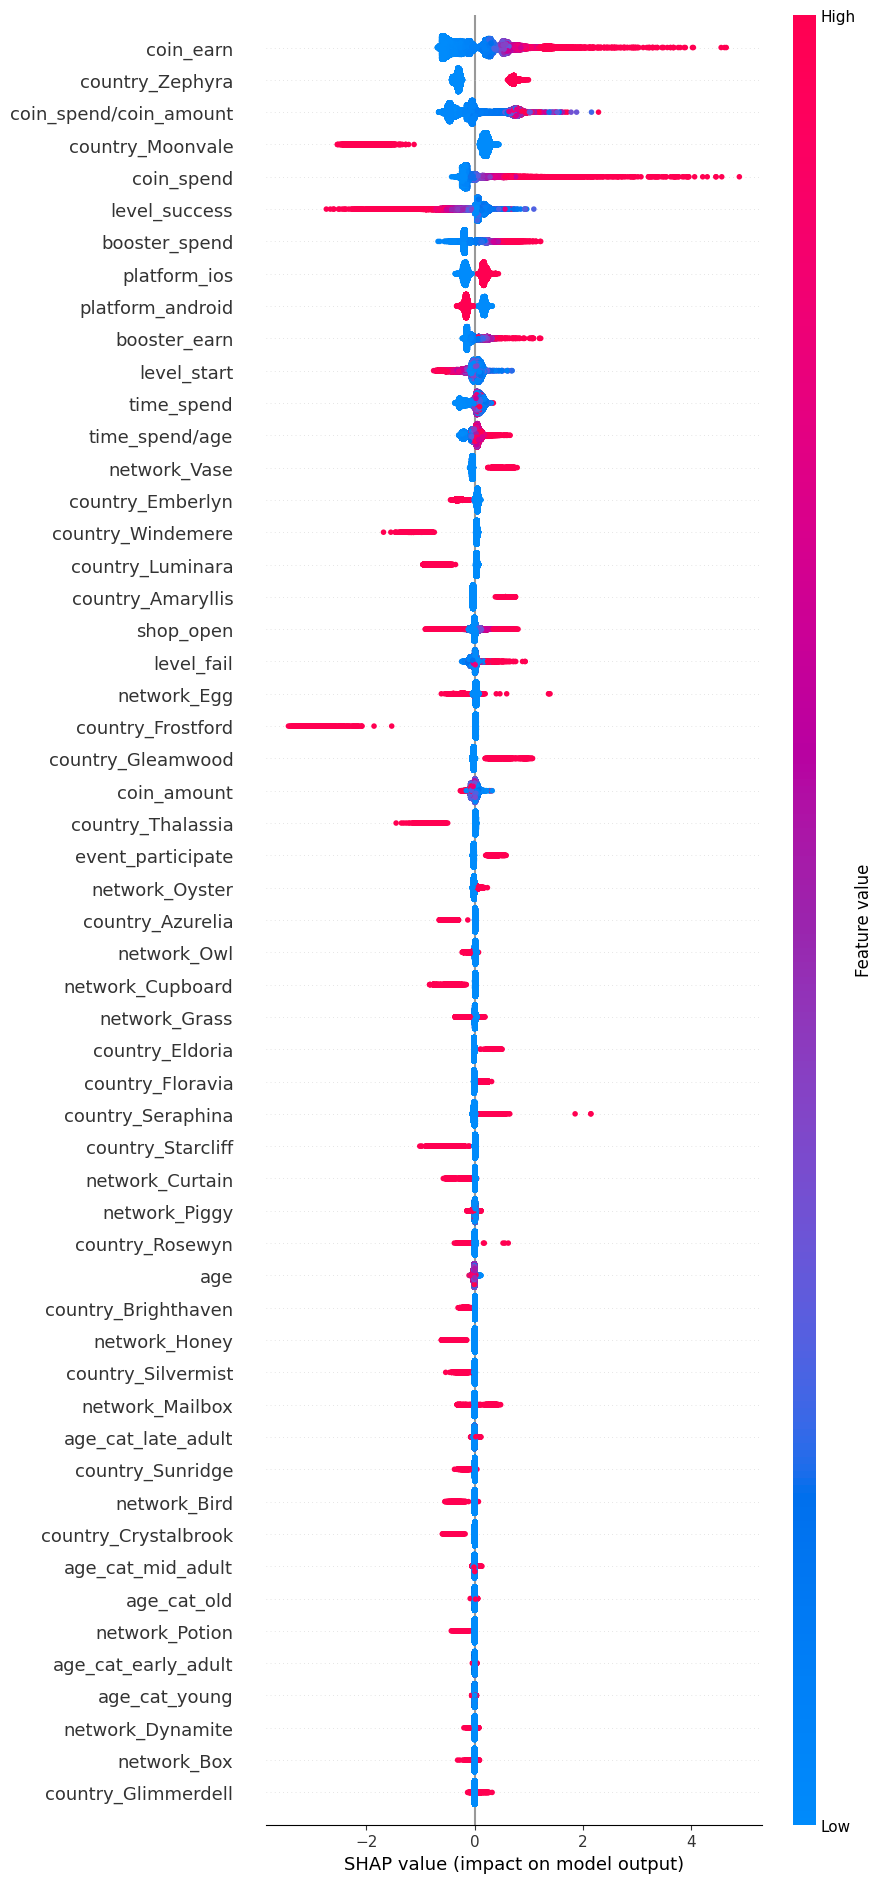

In [147]:
# BeeSwarm
shap.plots.beeswarm(shap_values, max_display=100)

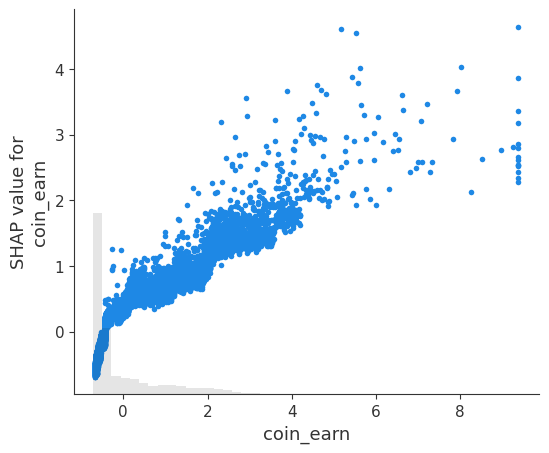

In [148]:
# Coin_Earn ile purchase dogru orantili
shap.plots.scatter(shap_values[:, "coin_earn"])

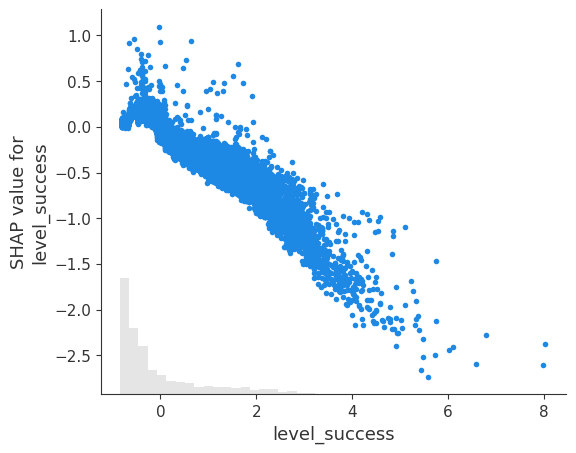

In [152]:
# level_succes ile purchase ters orantili
shap.plots.scatter(shap_values[:, "level_success"])

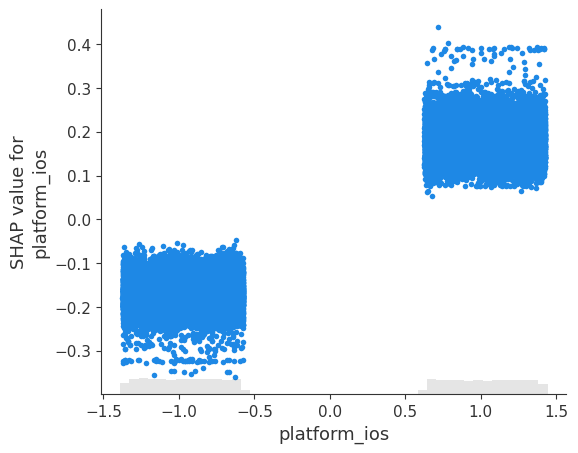

In [156]:
# ios kullanmak satin alma ihtimalini artiriyor
shap.plots.scatter(shap_values[:, "platform_ios"])

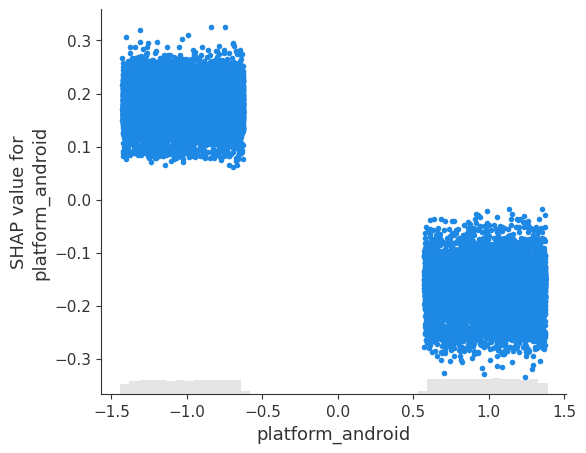

In [157]:
# android kullanmak satin alma ihtimalini azaltiyor.
shap.plots.scatter(shap_values[:, "platform_android"])